# Example 14: RVT SRA with multiple motions and simulated profiles

Example with multiple input motions and simulated soil profiles.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pystrata

%matplotlib inline

/home/albert/Documents/programs/pystrata/pystrata/propagation.py:66: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit


In [2]:
# Increased figure sizes
plt.rcParams["figure.dpi"] = 120

## Create a point source theory RVT motion

In [3]:
motions = [
    pystrata.motion.SourceTheoryRvtMotion(5.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(6.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(7.0, 30, "wna"),
]

for m in motions:
    m.calc_fourier_amps()

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [4]:
profile = pystrata.site.Profile(
    [
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=100),
            10,
            400,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=200),
            10,
            450,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=400),
            30,
            600,
        ),
        pystrata.site.Layer(pystrata.site.SoilType("Rock", 24.0, None, 0.01), 0, 1200),
    ]
)

## Create the site response calculator

In [5]:
calc = pystrata.propagation.EquivalentLinearCalculator()

## Initialize the variations

In [6]:
var_thickness = pystrata.variation.ToroThicknessVariation()
var_velocity = pystrata.variation.DepthDependToroVelVariation.generic_model("USGS C")
var_soiltypes = pystrata.variation.SpidVariation(-0.5, std_mod_reduc=0.15, std_damping=0.30)

## Specify the output

In [7]:
freqs = np.logspace(-1, 2, num=500)

outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.ResponseSpectrumRatioOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.InitialVelProfile(),
        pystrata.output.MaxAccelProfile(),
    ]
)

## Perform the calculation

In [8]:
count = 20
outputs.reset()
for i, p in enumerate(
    pystrata.variation.iter_varied_profiles(
        profile,
        count,
        # var_thickness=var_thickness,
        var_velocity=var_velocity,
        # var_soiltypes=var_soiltypes
    )
):
    # Here we auto-descretize the profile for wave propagation purposes
    p = p.auto_discretize()
    for j, m in enumerate(motions):
        name = (f"p{i}", f"m{j}")
        calc(m, p, p.location("outcrop", index=-1))
        outputs(calc, name=name)

## Plot the outputs

Create a few plots of the output.

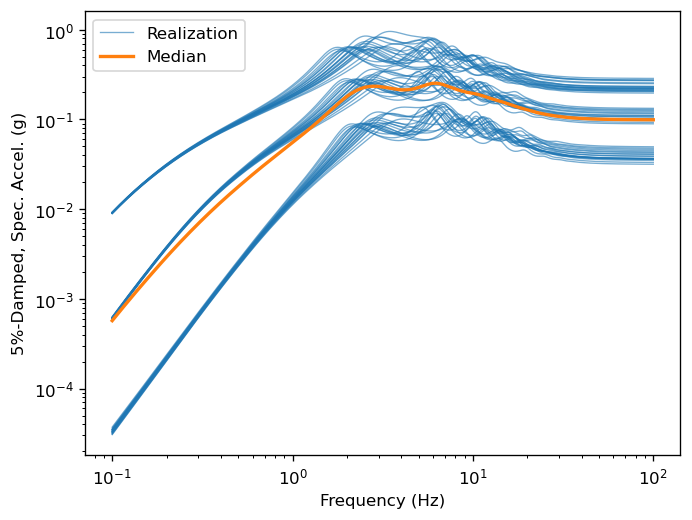

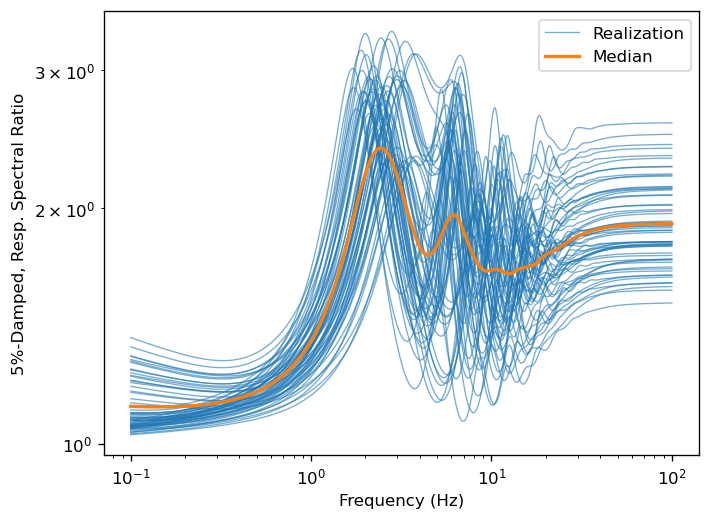

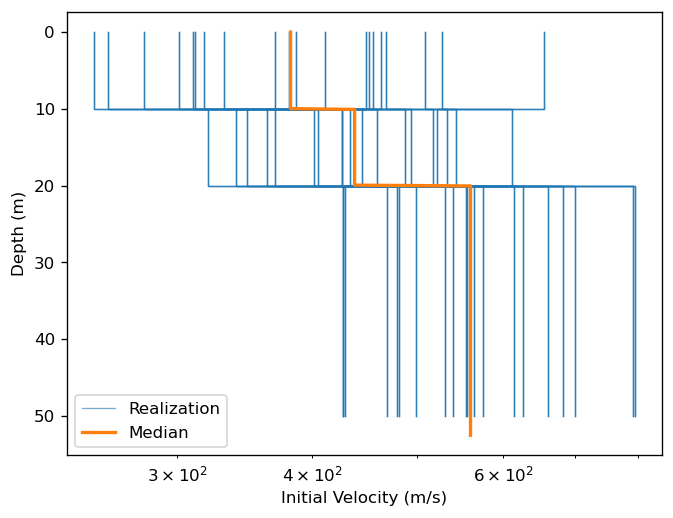

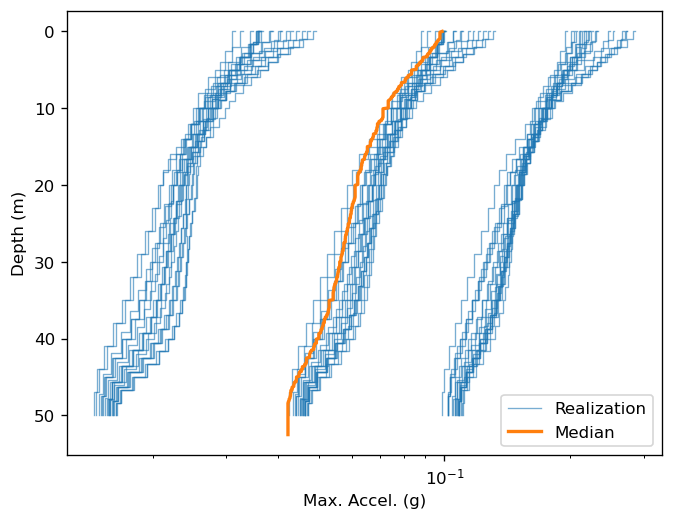

In [9]:
for o in outputs:
    ax = o.plot(style="stats")

## Manipulating output as dataframe

If a `tuple` is passed as the output name, it is used to create a `pandas.MultiIndex` columns.

In [10]:
df = outputs[1].to_dataframe()
df

p0                            p1                      \
                  m0        m1        m2        m0        m1        m2   
0.100000    1.231647  1.077873  1.049115  1.197000  1.071592  1.048212   
0.101394    1.230832  1.077809  1.049490  1.196450  1.071543  1.048580   
0.102807    1.230019  1.077749  1.049869  1.195902  1.071500  1.048952   
0.104240    1.229209  1.077695  1.050253  1.195357  1.071461  1.049328   
0.105693    1.228403  1.077647  1.050640  1.194813  1.071427  1.049707   
...              ...       ...       ...       ...       ...       ...   
94.613238   2.211307  2.079693  1.924936  2.570554  2.385653  2.203824   
95.932095   2.211378  2.079764  1.925035  2.570623  2.385725  2.203947   
97.269336   2.211447  2.079833  1.925132  2.570690  2.385795  2.204066   
98.625218   2.211513  2.079900  1.925225  2.570754  2.385862  2.204181   
100.000000  2.211577  2.079965  1.925315  2.570817  2.385928  2.204292   

                  p2                            p3  ...       p16       p17  \
                  m0        m1        m2        m0  ...        m2        m0   
0.100000    1.219305  1.072940  1.045238  1.205701  ...  1.029487  1.202974   
0.101394    1.218507  1.072880  1.045587  1.204985  ...  1.029724  1.202348   
0.102807    1.217712  1.072826  1.045940  1.204271  ...  1.029962  1.201723   
0.104240    1.216921  1.072776  1.046296  1.203560  ...  1.030204  1.201101   
0.105693    1.216132  1.072733  1.046656  1.202852  ...  1.030447  1.200482   
...              ...       ...       ...       ...  ...       ...       ...   
94.613238   1.888208  1.810304  1.681776  2.016767  ...  1.673231  2.334561   
95.932095   1.888281  1.810376  1.681866  2.016825  ...  1.673280  2.334635   
97.269336   1.888352  1.810446  1.681953  2.016882  ...  1.673328  2.334706   
98.625218   1.888420  1.810514  1.682037  2.016937  ...  1.673374  2.334775   
100.000000  1.888487  1.810580  1.682119  2.016990  ...  1.673418  2.334841   

                                     p18                           p19  \
                  m1        m2        m0        m1        m2        m0   
0.100000    1.070822  1.045970  1.294397  1.094992  1.058907  1.162859   
0.101394    1.070772  1.046323  1.293222  1.094893  1.059349  1.162337   
0.102807    1.070727  1.046681  1.292050  1.094801  1.059795  1.161816   
0.104240    1.070687  1.047041  1.290882  1.094714  1.060247  1.161298   
0.105693    1.070652  1.047405  1.289718  1.094635  1.060703  1.160782   
...              ...       ...       ...       ...       ...       ...   
94.613238   2.197280  2.076879  2.021386  1.913762  1.716689  1.873921   
95.932095   2.197348  2.076980  2.021479  1.913863  1.716810  1.873965   
97.269336   2.197414  2.077078  2.021569  1.913961  1.716927  1.874009   
98.625218   2.197478  2.077174  2.021656  1.914056  1.717040  1.874051   
100.000000  2.197539  2.077266  2.021741  1.914148  1.717151  1.874092   

                                
                  m1        m2  
0.100000    1.055110  1.033924  
0.101394    1.055078  1.034193  
0.102807    1.055051  1.034464  
0.104240    1.055028  1.034739  
0.105693    1.055010  1.035016  
...              ...       ...  
94.613238   1.793903  1.705542  
95.932095   1.793941  1.705595  
97.269336   1.793977  1.705646  
98.625218   1.794013  1.705696  
100.000000  1.794048  1.705744  

[500 rows x 60 columns]

Lets names to the dataframe and transform into a long format. Pandas works better on long formatted tables.

In [11]:
# Add names for clarity
df.columns.names = ("profile", "motion")
df.index.name = "freq"
# Transform into a long format
df = df.reset_index().melt(id_vars="freq")
df

,freq,profile,motion,value
0,0.100000,p0,m0,1.231647
1,0.101394,p0,m0,1.230832
2,0.102807,p0,m0,1.230019
3,0.104240,p0,m0,1.229209
4,0.105693,p0,m0,1.228403
...,...,...,...,...
29995,94.613238,p19,m2,1.705542
29996,95.932095,p19,m2,1.705595
29997,97.269336,p19,m2,1.705646
29998,98.625218,p19,m2,1.705696


In [12]:
def calc_stats(group):
    ln_value = np.log(group["value"])

    median = np.exp(np.mean(ln_value))
    ln_std = np.std(ln_value)

    return pd.Series({"median": median, "ln_std": ln_std})


stats = df.groupby(["freq", "motion"]).apply(calc_stats)
stats

median    ln_std
freq       motion                    
0.100000   m0      1.231543  0.049358
           m1      1.077237  0.016948
           m2      1.048476  0.010916
0.101394   m0      1.230709  0.049143
           m1      1.077170  0.016921
...                     ...       ...
98.625218  m1      1.928147  0.108943
           m2      1.778901  0.108629
100.000000 m0      2.032518  0.120840
           m1      1.928217  0.108943
           m2      1.778992  0.108628

[1500 rows x 2 columns]

In [13]:
stats = (
    stats.reset_index("motion").pivot(columns="motion").swaplevel(0, 1, axis=1).sort_index(axis=1)
)
stats

motion            m0                  m1                  m2          
              ln_std    median    ln_std    median    ln_std    median
freq                                                                  
0.100000    0.049358  1.231543  0.016948  1.077237  0.010916  1.048476
0.101394    0.049143  1.230709  0.016921  1.077170  0.010988  1.048845
0.102807    0.048929  1.229877  0.016894  1.077109  0.011060  1.049218
0.104240    0.048715  1.229049  0.016867  1.077052  0.011134  1.049595
0.105693    0.048501  1.228223  0.016842  1.077002  0.011207  1.049976
...              ...       ...       ...       ...       ...       ...
94.613238   0.120844  2.032228  0.108943  1.927923  0.108629  1.778613
95.932095   0.120843  2.032304  0.108943  1.928000  0.108629  1.778712
97.269336   0.120842  2.032378  0.108943  1.928075  0.108629  1.778808
98.625218   0.120841  2.032449  0.108943  1.928147  0.108629  1.778901
100.000000  0.120840  2.032518  0.108943  1.928217  0.108628  1.778992

[500 rows x 6 columns]

Access the properties of each motion like:

In [14]:
stats["m0"]

,ln_std,median
freq,,
0.100000,0.049358,1.231543
0.101394,0.049143,1.230709
0.102807,0.048929,1.229877
0.104240,0.048715,1.229049
0.105693,0.048501,1.228223
...,...,...
94.613238,0.120844,2.032228
95.932095,0.120843,2.032304
97.269336,0.120842,2.032378


/tmp/ipykernel_75490/2734831165.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for name, g in stats.groupby(level=0, axis=1):


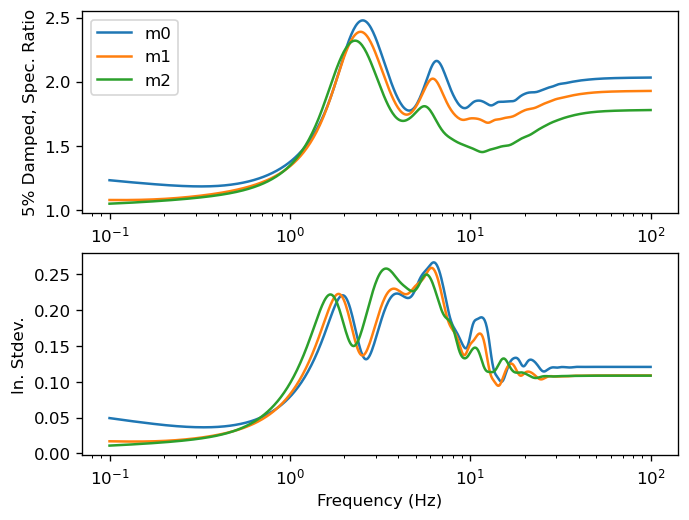

In [15]:
fig, axes = plt.subplots(nrows=2, subplot_kw={"xscale": "log"})

for name, g in stats.groupby(level=0, axis=1):
    for ax, key in zip(axes, ["median", "ln_std"]):
        ax.plot(g.index, g[(name, key)], label=name)


axes[0].set(ylabel="5% Damped, Spec. Ratio")
axes[0].legend()

axes[1].set(ylabel="ln. Stdev.", xlabel="Frequency (Hz)")

fig;